In [ ]:
# importing resources

%matplotlib inline

import numpy as np
import numpy as py

import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import torch.optim as optm
import PIL
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pypt
from matplotlib import animation
from IPython.display import HTML
import scipy.ndimage as ndimage
import scipy.ndimage as nd
from IPython.display import clear_output, Image, display
from io import BytesIO

In [ ]:
# geting the "features" function of VGG19 library
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters for we only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
# move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Transforming the image uploaded and convert it to RGB and resize and 
# normalizing it then returns

def load_image(img_path, max_size=400, shape=None):
    
    image = PIL.Image.open(img_path).convert('RGB')
    
    #note smller images can be processed fast
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [ ]:
# uploading images via colab library function upload

from google.colab import files
files.upload()
from IPython.display import clear_output
clear_output()

In [ ]:
# assignment of the image path to variable content and style separately and resize them

content = load_image('content.jpg').to(device)
style = load_image('style.png', shape=content.shape[-2:]).to(device)

In [ ]:
# un-normalizeing and converting the tensorflow image to numpy image

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * py.array((0.229, 0.224, 0.225)) + py.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

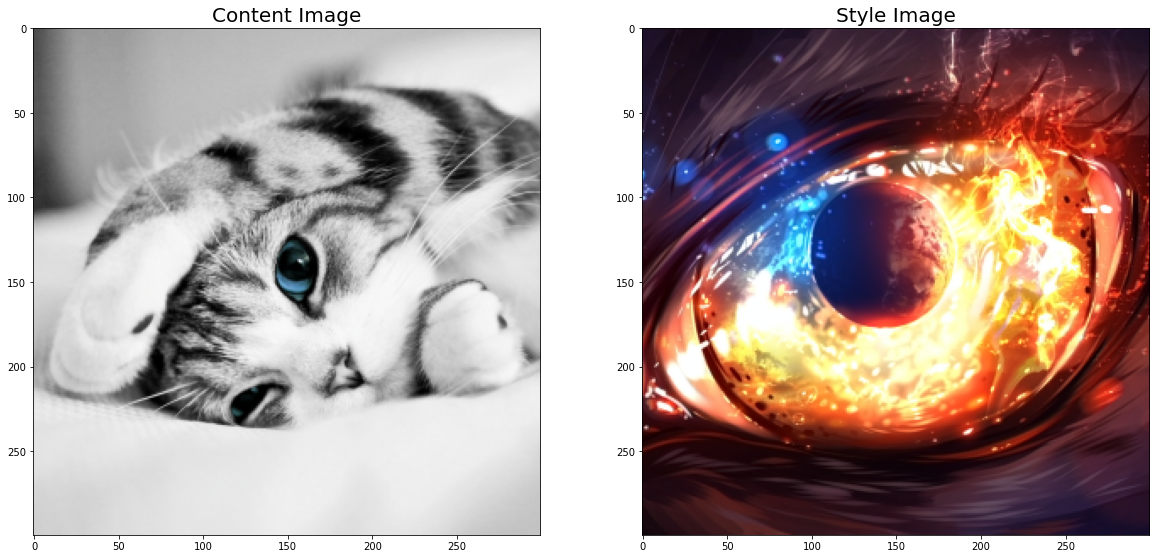

In [ ]:
# display the images returned using the above function
fig, (ax1, ax2) = pypt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(im_convert(content))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize = 20)
pypt.show()

In [ ]:
# display layers from the vgg19 structure
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
 # Run an image forward through a model and get the features for a set of layers.

def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
# Calculate the Gram Matrix

def gram_matrix(tensor):
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [ ]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change starting with the target as a copy of our *content* image then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# weights for each style layer. weighting earlier layers more will result in *larger* style artifacts

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

Total loss:  30695346176.0


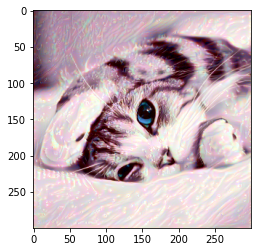

Total loss:  18297139200.0


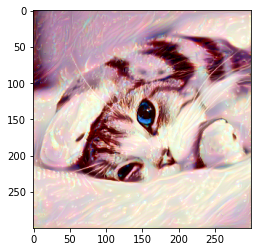

Total loss:  12071094272.0


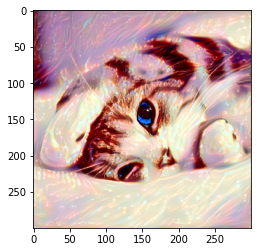

Total loss:  8288698368.0


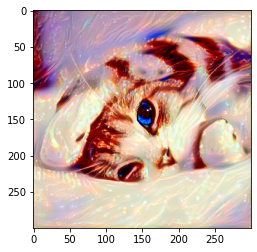

Total loss:  6052572160.0


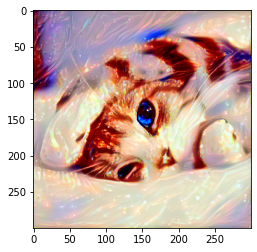

In [ ]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optm.Adam([target], lr=0.003)
# decide how many iterations to update image (5000)
steps = 2000  

for ii in range(1, steps+1):
    
    # get the features from target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        pypt.imshow(im_convert(target))
        pypt.show()

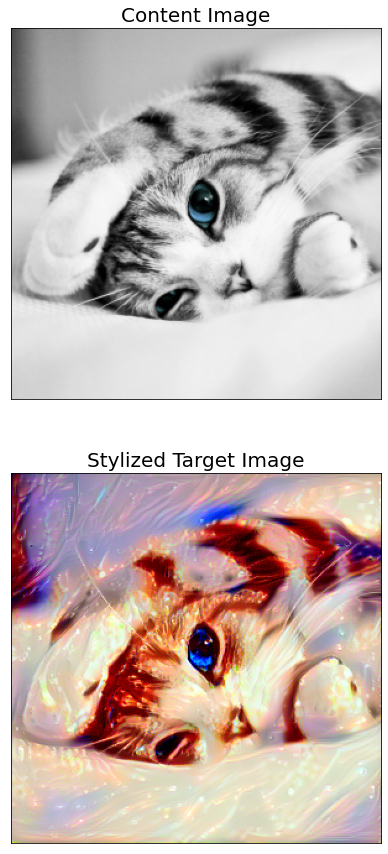

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = pypt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
pypt.show()

In [ ]:
# Saves the stylized output as stylized.png

In [ ]:
# DIIPDRIIM

In [ ]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)
    
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)
    
    if size is not None:
        img.thumbnail(size, PIL.Image.ANTIALIAS)
        
    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

def octaver_fn(model, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base

    return src

def filter_step(model, img, layer_index, filter_index, step_size=5, display=True, use_L2=False):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    model.zero_grad()
    
    img_var = image_to_variable(torch.Tensor(img), requires_grad=True, cuda=use_gpu)
    optimizer = SGD([img_var], lr=step_size, weight_decay=1e-4)
    
    x = img_var
    for index, layer in enumerate(model.features):
        x = layer(x)
        if index == layer_index:
            break

    output = x[0, filter_index]
    loss = output.norm() #torch.mean(output)
    loss.backward()
    
    if use_L2:
        #L2 normalization on gradients
        mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2) + 1e-5])
        if use_gpu:
            mean_square = mean_square.cuda()
        img_var.grad.data /= torch.sqrt(mean_square)
        img_var.data.add_(img_var.grad.data * step_size)
    else:
        optimizer.step()
    
    result = img_var.data.cpu().numpy()
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    
    if display:
        showtensor(result)
    
    return torch.Tensor(result)

def visualize_filter(model, base_img, layer_index, filter_index, 
                     octave_n=6, octave_scale=1.4, iter_n=10, 
                     step_size=5, display=True, use_L2=False):
    
    return octaver_fn(
                model, base_img, step_fn=filter_step, 
                octave_n=octave_n, octave_scale=octave_scale, 
                iter_n=iter_n, layer_index=layer_index, 
                filter_index=filter_index, step_size=step_size, 
                display=display, use_L2=use_L2
            )

def show_layer(layer_num, filter_start=10, filter_end=20, step_size=7, use_L2=False):
    filters = []
    titles = []
    
    _, _, img_np = init_image(size=(600, 600, 3))
    for i in range(filter_start, filter_end):
        title = "Layer {} Filter {}".format(layer_num , i)
        print(title)
        filter = visualize_filter(model, img_np, layer_num, filter_index=i, octave_n=2, iter_n=20, step_size=step_size, display=True, use_L2=use_L2)
        filter_img = tensor_to_img(filter)
        filter_img.save(title + ".jpg")
        filters.append(tensor_to_img(filter))
        titles.append(title)
        
    
    plot_images(filters, titles)
    return filters, titles

def objective(dst, guide_features):
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        if use_gpu:
            diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        else: 
            diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])) 
        return diff

def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    model.zero_grad()
      
    x = img_var
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if use_gpu:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)
                                                             
def deepdream(model, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              model, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

In [ ]:
inputImage = './content.jpg'
guideImage = './style.png'
model = models.densenet121(pretrained=True) # add pretrained=True if not on Kaggle
# model.load_state_dict(torch.load("densenet121.pth"))

use_gpu = False
if torch.cuda.is_available():
    use_gpu = True

for param in model.parameters():
    param.requires_grad = False

if use_gpu:
    #print("Using CUDA")
    model.cuda()

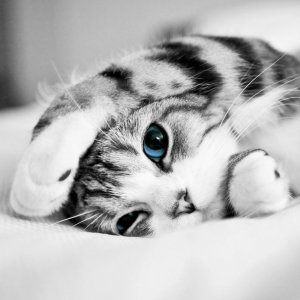

In [ ]:
input_img, input_tensor, input_np = load_image(inputImage, size=[1024, 1024])
#print(input_img.size)
input_img

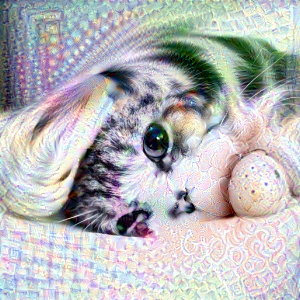

In [ ]:
# generate a deepdream model version 1
dream = deepdream(model, input_np, end=7, step_size=0.06, octave_n=6)
dream = tensor_to_img(dream)
dream.save('densenet121dream.jpg')
dream

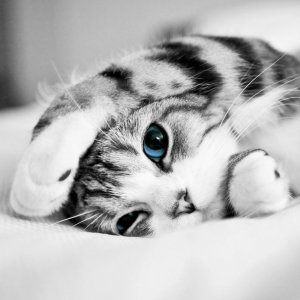

In [ ]:
input_img, input_tensor, input_np = load_image(inputImage, size=[1024, 1024])
#print(input_img.size)
input_img

In [ ]:
inputImage = './content.jpg'
guideImage = './content.jpg'
model = models.vgg16(pretrained=True)
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
for param in model.parameters():
    param.requires_grad = False
if use_gpu:
    #printing Using CUDA
    model.cuda()

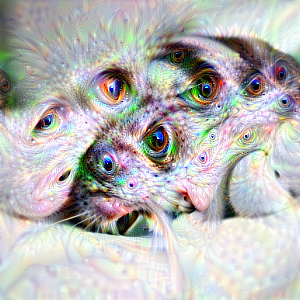

In [ ]:
# generate a deepdream model version 2
dream = deepdream(model, input_np, end=28, step_size=0.06, octave_n=6)
dream = tensor_to_img(dream)
dream.save('vgg16_dream.jpg')
dream

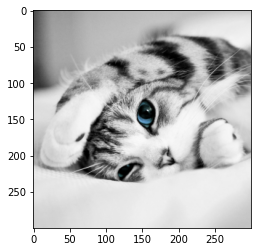

In [ ]:
guide_img, guide_img_tensor, guide_img_np = load_image(guideImage, resize=True)
plt.imshow(guide_img)
guide_features = image_to_variable(guide_img_tensor, cuda=use_gpu)
end=28
for index, layer in enumerate(model.features.children()):
    guide_features = layer(guide_features)
    if index == end:
        break 

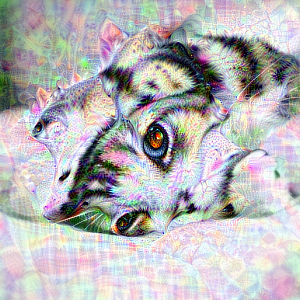

In [ ]:
# generate a deepdream model version 3
dream = deepdream(model, input_np, end=30, step_size=0.08, octave_n=6, 
                  control=guide_features)
dream = tensor_to_img(dream)
dream.save('vgg16_guided_dream.jpg')
dream

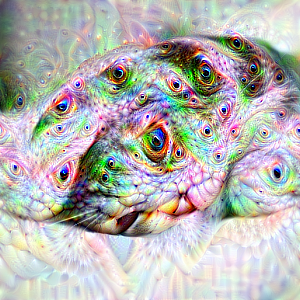

In [ ]:
# generate a deepdream model version 4
dream = deepdream(model, input_np, end=28, step_size=0.1, octave_n=6)
dream = tensor_to_img(dream)
dream.save('vgg16_dream.jpg')
dream